# Filtered state preparation with GQSP

Ground state preparation is a fundamental task in quantum computation, serving as a cornerstone for simulating strongly correlated systems in chemistry, material sciences and physics.
Understanding the ground state, i.e., the state of lowest energy, is essential for predicting a system's stability, electronic properties, and chemical reactivity.
At the macroscopic level, the behavior of most materials at low temperatures is governed by their ground state configuration. For instance:

-   In Chemistry: The ground state determines the equilibrium geometry of molecules. Knowing this energy level allows us to calculate reaction rates and understand how catalysts lower the energy barriers for specific processes.
-   In Material Science: Key phenomena such as superconductivity and magnetism are emergent properties of the ground state in many-body systems.
-   In Physics: Identifying the ground state of a Hamiltonian like the Heisenberg model reveals whether a material will behave as an insulator, a metal, or a more exotic phase of matter, such as a quantum spin liquid.

However, finding the ground state is a notoriously difficult challenge. In fact, ground state preparation is QMA-complete, meaning it is generally hard even for quantum computers to find the exact solution for any arbitrary Hamiltonian. In practice, we often circumvent this complexity by starting with a 'good enough' initial guess (a trial state) and employing quantum algorithms, e.g., [Gluza et al.](https://journals.aps.org/prl/abstract/10.1103/rw81-k8vk), to systematically lower the system's energy, a process often referred to as algorithmic cooling.

In this tutorial, we explore how to use [Generalized Quantum Signal Processing](https://journals.aps.org/prxquantum/pdf/10.1103/PRXQuantum.5.020368) for this task:
starting from an initial system state for a Heisenberg model, we apply a Gaussian filter to enhance the overlap of the prepared state with the ground state.

## Contents

-   [1. Heisenberg model](#1.-Heisenberg-model)
    -   [1.1. Spectral analysis](#1.1-Spectral-analysis)

-   [2. Eigenstate Filtering](#2.-Eigenstate-Filtering)

-   [3. Deep Dive: The Theory and Implementation](#3.-Deep-Dive:-The-Theory-and-Implementation)<br>
    -   [3.1 Introduction to Block-Encodings and GQSP](#3.1-Introduction-to-Block-Encodings-and-GQSP)<br>
    -   [3.2 Pauli Block-Encodings](#3.2-Pauli-Block-Encodings)<br>
    -   [3.3 Implementation](#3.3-Implementation)<br>

-   [4. Conclusion](#4.-Conclusion)<br>


This tutorial guides you through the process using the example of a Heisenberg model. First, we will set up the model and perform a classical analysis of its spectrum and our initial state.
Next, we introduce the concept of eigenstate filtering and demonstrate how to use Qrisp’s BlockEncoding abstraction with built-in quantum signal processing features to isolate the ground state.
Finally, we take a deep dive into the theory of block-encodings and GQSP, providing a detailed look at the implementation.


## 1. Heisenberg model

Let us consider an $L$-qubit antiferromagnetic Heisenberg model

$$ H = \sum_{i=0}^{L-1}(X_iX_{i+1} + Y_iY_{i+1} + Z_iZ_{i+1}) $$

Physically, [antiferromagnetism](https://en.wikipedia.org/wiki/Antiferromagnetism) describes materials where neighboring spins "want" to point in opposite directions $\uparrow\downarrow$ to reach the lowest energy state. Unlike a standard fridge magnet (where spins point the same way), an antiferromagnet has no net external magnetism. These models are crucial for understanding quantum materials, such as high-temperature superconductors.

As initial system state we choose a tensor product of Singlet states

$$ \ket{\text{Singlet}} = 2^{-L/4}(\ket{10}-\ket{01})^{\otimes L/2} $$

of consecutive qubits. Starting at our initial state $\ket{\text{Singlet}}$, we aim to prepare a state with an even higher overlap with the ground state of the [operator](../../reference/Operators/QubitOperator.rst)  $H$. 

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from qrisp import *
from qrisp.gqsp import GQSP
from qrisp.operators import X, Y, Z
from qrisp.vqe.problems.heisenberg import create_heisenberg_init_function


def generate_1D_chain_graph(L):
    graph = nx.Graph()
    graph.add_edges_from([(k, (k+1)%L) for k in range(L-1)])
    return graph


# Define Heisenberg Hamiltonian with spectrum in [-1,1].
L = 10
G = generate_1D_chain_graph(L)
H = (1 / (3 * L - 3)) * sum((X(i) * X(j) + Y(i) * Y(j) + Z(i) * Z(j)) \
                            for i, j in G.edges())

# Finds a maximum matching M of the graph G.
# For a chain graph G, M contains every second edge of G.
M = nx.maximal_matching(G)
# Prepares a tensor product of Singlet states 
# corresponding to the edges in M when applied to 
# a QuantumVariable in state |0>.
U0 = create_heisenberg_init_function(M)


# Define initial state preparation function
# preparing a tensor product of Singlet states.
def psi_prep():
    operand = QuantumVariable(L)
    U0(operand)
    return operand


# Calculate the energy for the initial state.
# Computes the operator's expectation value using Pauli measurement settings.
E = H.expectation_value(psi_prep, precision=0.001)()
print(E)

-0.555883883883884                                                                   


### 1.1 Spectral Analysis

While this classical analysis does not scale to larger systems, it provides crucial intuition for the filtering approach by illustrating how it acts upon the Hamiltonian spectrum.
Let us take a closer look at the spectrum of this Hamiltonian, and the inital state $\ket{\psi_0}=\ket{\text{Singlet}}$. 
First, we compute all eigenvalues and the corresponding eigenvectors. Secondly, we calculate the fidelities of the initial state $\ket{\psi_0}$ and each eigenstate $\ket{\lambda_k}$.
Next, we find the indices $k$ of the eigenstates $\ket{\lambda_k}$ that have a significant overlap with the initial state, i.e., $F_k=|\langle \lambda_k | \psi_0 \rangle|^2>0.01$.

In [26]:
H_matrix = H.to_array()
eigvals, eigvecs = np.linalg.eigh(H_matrix)

idx = np.argsort(eigvals)
eigvals_sorted = eigvals[idx].real
eigvecs_sorted = eigvecs[:, idx]
print(f'Ground state energy: {eigvals_sorted[0]}\n') # lambda_0
print(f'First excited state energy: {eigvals_sorted[1]}\n') # lambda_1

psi0 = psi_prep().qs.statevector_array()
fidelities = np.abs(eigvecs_sorted.conj().T @ psi0) ** 2

threshold = 0.01
significant_mask = fidelities > threshold
indices = np.where(significant_mask)[0]

print(f'Indices: {indices}\n')
print(f'Eigenvalues: {eigvals_sorted[indices]}\n')
print(f'Fidelities: {fidelities[indices]}\n')

Ground state energy: -0.6308200307085748

First excited state energy: -0.5823220132594902

Indices: [  0   7  35  83 154 220]                                                   

Eigenvalues: [-0.63082003 -0.50314048 -0.38308217 -0.28333426 -0.21195784 -0.15485291]

Fidelities: [0.68261391 0.13067813 0.10160195 0.04302465 0.01256852 0.01153198]



We observe that the initial state already has fidelity $F_0 \approx 0.68$ with the ground state $\ket{\lambda_0}$ with energy $\lambda_0 \approx -0.63$. 
Moreover, the inital state has a significant overlap with only 5 higher energy eigenstates.

## 2. Eigenstate Filtering

Starting at our initial state $\ket{\psi_0}$, we aim to prepare a state with an even higher overlap with the ground state $\ket{\lambda_0}$. 
Therefore, we aim to apply a [Gaussian filter](https://en.wikipedia.org/wiki/Gaussian_filter) centered at $\lambda_0$ which suppresses higher energy components: indeed for 

$$ H = \sum_i\lambda_i\ket{\lambda_i}\bra{\lambda_i}\quad \text{and}\quad \ket{\psi_0} = \sum_i\alpha_i\ket{\lambda_i} $$

the state $\ket{\psi}$ after applying the filter $f$ is

$$ \ket{\psi} = \frac{f(H)\ket{\psi_0}}{\|f(H)\ket{\psi_0}\|} $$

where

$$ f(H)\ket{\psi_0} = \left(\sum_i f(\lambda_i)\ket{\lambda_i}\bra{\lambda_i}\right) \sum_j\alpha_j\ket{\lambda_j} = \sum_i f(\lambda_i)\alpha_i\ket{\lambda_i} $$

Thus, the magnitude of the amplitude of $\ket{\lambda_i}$ for $i>0$ is suppressed relative to the amplitude of $\ket{\lambda_0}$ in the state $\ket{\psi}$.

This filter is approximated by [Chebyshev polynomials](https://en.wikipedia.org/wiki/Chebyshev_polynomials) of the first kind. 
Chebyshev polynomials $T_n(x)$ are a sequence of orthogonal functions defined by the recurrence: $T_0(x)=1$, $T_1(x)=x$ and $T_{n+1}(x)=2xT_n(x)-T_{n-1}(x)$.
They are crucial for quantum algorithms (and approximation theory in gerneral) because: 1) They minimize the maximum error when approximating functions like our Gaussian filter. 2) Quantum Signal Processing naturally implements transformations of a Hermitian operator $H$ as a polynomial expansion in the Chebyshev basis.


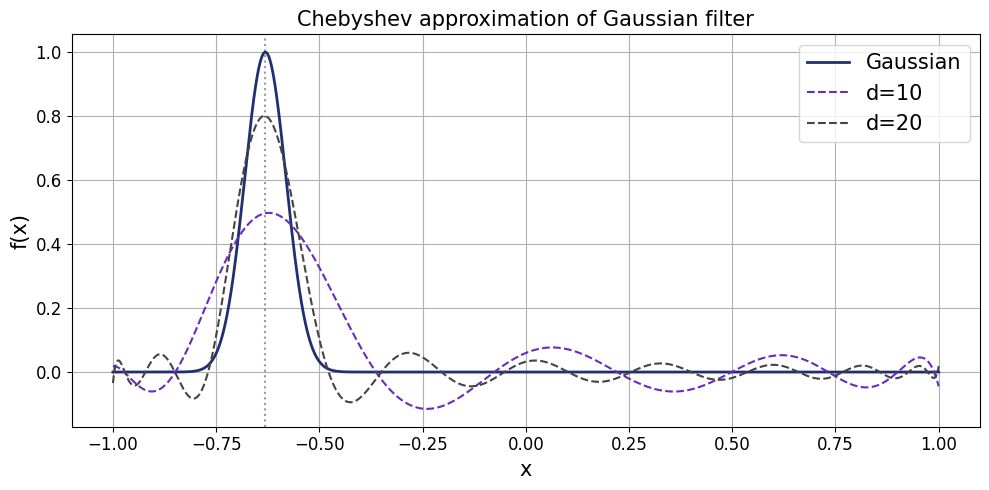

In [27]:
from numpy.polynomial import Chebyshev
from numpy.polynomial.chebyshev import chebval

# Define the Gaussian centered at minimal eigenvalue lambda_0 on [-1, 1].
mu = eigvals_sorted[0]
sigma = 0.05

def gaussian(x):
    return np.exp(-0.5 * ((x - mu) / sigma) ** 2)

# Chebyshev fit
x_nodes = np.cos(np.pi * np.arange(201) / 200)
f_nodes = gaussian(x_nodes)
cheb_fit = Chebyshev.fit(x_nodes, f_nodes, deg=100)
cheb_coeffs = cheb_fit.coef

x_plot = np.linspace(-1, 1, 2000)
f_gaussian = gaussian(x_plot)
f_cheb_10 = chebval(x_plot, cheb_coeffs[:11]) 
f_cheb_20 = chebval(x_plot, cheb_coeffs[:21])  

# Plot
plt.figure(figsize=(10, 5))
plt.plot(x_plot, f_gaussian, color='#20306f', label='Gaussian', linewidth=2)
plt.plot(x_plot, f_cheb_10, color='#6929C4', label='d=10', linestyle='--')
plt.plot(x_plot, f_cheb_20, color='#444444', label='d=20', linestyle='--')
plt.axvline(mu, color='k', linestyle=':', alpha=0.4)
plt.xlabel('x', fontsize=15)
plt.xticks(fontsize=12)
plt.ylabel('f(x)', fontsize=15)
plt.yticks(fontsize=12)
plt.title('Chebyshev approximation of Gaussian filter', fontsize=15)
plt.legend(fontsize=15)
plt.grid()
plt.tight_layout()
plt.show()

Let us now apply the filter using the built-in features of Qrisp's [BlockEncoding](../../reference/Block%20Encodings/BlockEncoding.rst) programming abstraction.

We will delve deeper into block-encodings shortly; for now, think of them as a way to make Hermitian operators accessible for computation on a quantum computer.

In [28]:
from qrisp.block_encodings import BlockEncoding

# Encodes the operator $H$.
BE = BlockEncoding.from_operator(H)

# Encodes the operator p(H) for a degree 10 Chebychev approximation 
# of the Gaussian filter.
BE_filter = BE.poly(cheb_coeffs[:11], kind="Chebyshev") 

# Returns the filtered state.
def filtered_psi_prep():
    # Applies p(H) to the inital state |psi_0>.
    operand = BE_filter.apply_rus(psi_prep)()
    return operand

In [29]:
@jaspify(terminal_sampling=True)
def main(): 

    E = H.expectation_value(filtered_psi_prep, precision=0.001)()
    return E

print(main())

-0.6183163163163162                                                                  


Indeed, we achieve a significantly lower energy ($\approx -0.62$ versus $\approx -0.56$) -- hence, a higher overlap with the ground state (energy $\approx -0.63$) -- for the transformed state after QSP. 

Let us note that, in general, we cannot deduce a higher ground state fidelity just form decreased energy. 
However, if the observed energy lies within the spectral gap $\Delta=\lambda_1-\lambda_0$ of the ground state energy $\lambda_0$, we can use the following observation:

Suppose that the state $\ket{\psi}$ has overlap with only the ground state and the first excited state, i.e., 
$\ket{\psi} = \alpha_0\ket{\lambda_0} + \alpha_1\ket{\lambda_1}$. Then the energy $E$ evaluates to 

$$ E = \langle\psi|H|\psi\rangle = \langle\psi|\sum_i\lambda_i\ket{\lambda_i}\bra{\lambda_i}|\psi\rangle = |\alpha_0|^2\lambda_0 + |\alpha_1|^2\lambda_1 $$

where $F_0=|\alpha_0|^2$ is the fidelity with the ground state. Writing $|\alpha_1|^2=1-F_0$, we find 

$$ F_0=\dfrac{\lambda_1-E}{\Delta} $$

where $\Delta=\lambda_1-\lambda_0$ is the spectral gap.

This equation provides a lower bound on the ground state fidelity whenever the observed energy lies within the spectral gap of the ground state energy $\lambda_0$.
Clearly, if the state $\ket{\psi}$ would overlap with additional higher energy excited states, the fidelity $F_0$ would be even higher.

In our example, we find

$$ F_0 \geq \dfrac{-0.58-(-0.62)}{-0.58-(-0.63)} = 0.8 $$

Assuming that our initial state has zero overlap with all excited states until $\ket{\lambda_7}$ at energy $\lambda_7\approx -0.50$, 
the above formula yields $F_0\geq 0.92$ which is a significant increase form the initial fidelity $F_0\approx 0.68$. 

## 3. Deep Dive: The Theory and Implementation

**But, how does this work?**

Essentially, we use [GQSP](../../reference/Algorithms/GQSP.rst) to apply a polynomial approximation of the Gaussian filter in Chebyshev basis resulting in the filtered state

$$ \ket{\psi}=\dfrac{p(H)\ket{\psi_0}}{\|p(H)\ket{\psi_0}\|} $$

Before we dive into the implementation details, let's establish a basic understanding of block-encodings and quantum signal processing.

### 3.1 Introduction to Block-Encodings and GQSP

If you have never heard of block-encodigs before, we recommend this [tutorial](https://www.qrisp.eu/general/tutorial/BE_tutorial/index.html). 
Otherwise, let us recall the notion of a block-encoding:

Block-encoding is a foundational technique that enables the implementation of non-unitary operations on a quantum computer by embedding them into a larger unitary operator.
Consider a normalized Pauli operator $H=\sum_i\alpha_iP_i$ where $\alpha_i>0$ are real coefficients such that $\sum_i|\alpha_i|=1$, and $P_i$ are Pauli strings acting on $n$ qubits (including their respective signs).
We embed $H$ into the upper-left block of a unitary matrix $U$:

$$ U = \begin{pmatrix} H & * \\ * & * \end{pmatrix} $$

More formally, a block-encoding of an operator $H$ (not necessarily unitary) acting on a Hilbert space $\mathcal H_{s}$ 
is a unitary acting on $\mathcal H_a\otimes H_s$ (for some auxiliary Hilbert space $\mathcal H_a$) such that

$$ (\bra{0}_a \otimes \mathbb I_s) U (\ket{0}_a \otimes \mathbb I_s) = H $$

Our next ingredient is [GQSP](../../reference/Algorithms/GQSP.rst): 
[Generalized Quantum Signal Processing](https://journals.aps.org/prxquantum/pdf/10.1103/PRXQuantum.5.020368) allows for applying polynomial transformations $p(U)$ of a **unitary** $U$.

Given a unitary $U$, and a complex degree $d$ polynomial $p(z)\in\mathbb C[z]$ that is bounded by 1 on the eunit circle, i.e., $|p(z)|^2\leq 1$ for $|z|=1$,
this algorithm implements a unitary

$$ \begin{pmatrix} p(U) & * \\ * & * \end{pmatrix} $$

hence, can be undestood as block-encoding of $p(U)$, i.e.,

$$ (\bra{0}_a \otimes \mathbb I_s) \text{GQSP}_{p,U} (\ket{0}_a \otimes \mathbb I_s) = p(U) $$

But, how can we actually realize $p(H)$ for a Hermitian operator $H$? This is achieved by a technique termed [qubitization](https://quantum-journal.org/papers/q-2019-07-12-163/):

Given a block-encoding unitary $U$ of a Hamiltonian $H$, such that $U^2=I$, let

$$ R=(2\ket{0}_a\bra{0}_a-I_a)\otimes I_s $$

be the [reflection](../../reference/Primitives/reflection.rst) around $\ket{0}_a$. Then $(RU)^k$ is a block-encoding of $T_k(H)$ where $T_k$ is the $k$-th Chebyshev polynomial of the first kind (see [Kirby et al.](https://quantum-journal.org/papers/q-2023-05-23-1018/pdf/)).

That is, using $RU$ as our unitary for [GQSP](../../reference/Algorithms/GQSP.rst), we effectively apply a polynomial of the Hermitian operator $H$ in Chebyshev basis. 
This algorithm is also referred to as Generalized Quantum Eigenvalue Transform (GQET).

### 3.2 Pauli Block-Encodings

First, we construct a block-encoding for the Pauli operator $H=\sum_i\alpha_iP_i$, where $\alpha_i>0$ are real coefficients and $P_i$ are Pauli strings (including their respective signs), 
using the Linear Combination of Unitaries (LCU) protocol:

We build our block-encoding unitary as $U=\text{PREP}^{\dagger}\cdot \text{SELECT}\cdot \text{PREP}$ where

$$ \text{SELECT} = \sum_i\ket{i}_a\bra{i}_a\otimes P_i $$

acts as a [quantum switch case](../../reference/Primitives/qswitch.rst) applying the $i$-th unitary $P_i$ conditioned on the ancilla being in state $\ket{i}_a$, and

$$ \text{PREP}\ket{0} = \sum_i\sqrt{\alpha_i}\ket{i}_a $$

[prepares](../../reference/Primitives/prepare.rst) a state encoding the coefficients.

Indeed, a direct calculation using $\langle i | j\rangle=\delta_{ij}$ shows

$$ 
\begin{align}
(\bra{0}_a \otimes \mathbb I_s) \text{PREP}^{\dagger}\cdot &\text{SELECT}\cdot \text{PREP} (\ket{0}_a \otimes \mathbb I_s) \\
&= \left(\sum_i \sqrt{\alpha_i}\bra{i}_a \otimes I_s\right) \left(\sum_j\ket{j}_a\bra{j}_a\otimes P_j\right) \left(\sum_k \sqrt{\alpha_k}\ket{k}_a\otimes I_s\right) \\
&= \sum_j \alpha_j P_j = H.
\end{align}
$$

In Qrisp, this Pauli block-encoding unitary can be defined as follows:

In [30]:
# Returns a list of unitaries, i.e., functions performing in-place operations 
# on the operand quantum variable, and a list of coefficients.
unitaries, coeffs = H.unitaries()
n = len(unitaries).bit_length() # Number of qubits for auxiliary variable.

# Define block-encoding unitary using LCU = PREP SELECT PREP_dg.
def U(anc, operand):
    with conjugate(prepare)(anc, coeffs):
        q_switch(anc, unitaries, operand) # quantum switch aka SELECT

## 3.3 Implementation

Next, we define a function for performing the filtered state prepation using [GQSP](../../reference/Algorithms/GQSP.rst).

Block-encodings and (generalized) quantum signal processing are applied to realize non-unitray transformations on a quantum computer. 
Thereby, the desired transformation is successfully realized upon projecting onto the subspace where the ancilla variables are in state $\ket{0}$.
In this example, the ancilla QuantumBool ``anc_qsp`` and QuantumFloat ``anc_be`` must both be measured in state $\ket{0}$. 
Hence, the filtered state preparation is embedded within a [Repeat-Until-Success](../../reference/Jasp/Control%20Flow/RUS.rst) protocol.

The ``RUS`` decorator is applied to a trial function that must return a boolean value as first return value.
The trial function is repeatedly executed until the boolean value is True, and the remaining return values are retuned.

In [31]:
@RUS
def filtered_psi_prep():

    # Qubitization step: RU^k is a block-encoding of T_k(H).
    def RU(case, operand):
        U(case, operand)
        reflection(case) # Reflection around |0>.


    # GQSP requires one 1-qubit ancilla variable.
    anc_qsp = QuantumBool()
    # Pauli block-encoding requires one n-qubit ancilla variable.
    anc_be = QuantumFloat(n)
    operand = psi_prep()

    # Apply degree 10 Chebyshev approximation of Gaussian filter.
    GQSP(anc_qsp, # Ancilla variable for GQSP protocol.
         anc_be, # Ancilla variable for block-encoding.
         operand, # Variable holding the system state |psi_0>.
         unitary=RU, # Block-encoding unitary.
         p=cheb_coeffs[:11], # Polynomial transformation to apply.
    )

    # Protocol is successful if all ancilla variables are measured in state |0>.
    success_bool = (measure(anc_qsp) == 0) & (measure(anc_be) == 0)
    # Release quantum resources.
    # The operand variable will be realeased automatically if success_bool=False.
    reset(anc_qsp)
    reset(anc_be)
    anc_qsp.delete()
    anc_be.delete()
    return success_bool, operand

In [32]:
@jaspify(terminal_sampling=True)
def main(): 

    E = H.expectation_value(filtered_psi_prep, precision=0.001)()
    return E

print(main())

-0.6201741741741742                                                                  


And voila, we again achieve a significantly lower energy ($\approx -0.62$ versus $\approx -0.56$) -- hence, a higher overlap with the ground state (energy $\approx -0.63$) -- for the transformed state after QSP. 

## 4. Conclusion

In this tutorial, we demonstrated how Quantum Signal Processing can be leveraged for ground state preparation. 
By applying a Gaussian filter to a Heisenberg model, we showcased how eigenstate filtering can systematically enhance the overlap with the target state.

Key takeaways include:

-   **The Versatility of Block-Encodings:** How Qrisp’s abstraction allows us to embed non-unitary operators, like our Heisenberg Hamiltonian, into quantum programs.
-   **Algorithmic Flexibility:** GQSP allows us to implement polynomial transformations, turning abstract mathematical filters into executable quantum programs.
-   **Scalability:** While we analyzed the spectrum classically for verification, the methods discussed here provide a scalable path towards exploring complex quantum systems that are beyond the reach of classical simulation.

As a next step, you might explore how different filter shapes (such as step functions for excited state isolation) or more complex Hamiltonians impact the performance of the algorithm.
For those interested in how these filtering techniques can be utilized to enhance other algorithms, we recommend exploring the work of Lee et al. (2025) on [Filtered Quantum Phase Estimation](https://arxiv.org/pdf/2510.04294), which further investigates the utility of spectral filters in the context of phase estimation.
